In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter

import sklearn.metrics as metrics
import sklearn.linear_model as linear_model
import sklearn.model_selection as model_selection
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline  


import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

In [2]:
df_features = pd.read_pickle("df_features_prueba.pickle")
df_features = pd.concat([df_features]*10)
df_features.head()

agrupacion_feature           media                                            \
feature                      delta         theta         alpha          beta   
tipo indice_paciente                                                           
P    0                1.640200e-11  3.212565e-12  1.062605e-12  1.094488e-12   
S    0                8.785838e-12  2.255187e-12  2.061689e-12  5.393903e-12   
P    0                1.640200e-11  3.212565e-12  1.062605e-12  1.094488e-12   
S    0                8.785838e-12  2.255187e-12  2.061689e-12  5.393903e-12   
P    0                1.640200e-11  3.212565e-12  1.062605e-12  1.094488e-12   

agrupacion_feature                                                             \
feature                      gamma delta_norm theta_norm alpha_norm beta_norm   
tipo indice_paciente                                                            
P    0                2.441766e-13   0.638982   0.178471   0.081279  0.076343   
S    0                6.346465e-12   0.321599   0.095496   0.089780  0.226482   
P    0                2.441766e-13   0.638982   0.178471   0.081279  0.076343   
S    0                6.346465e-12   0.321599   0.095496   0.089780  0.226482   
P    0                2.441766e-13   0.638982   0.178471   0.081279  0.076343   

agrupacion_feature                 ...              std                \
feature              gamma_norm    ...            alpha          beta   
tipo indice_paciente               ...                                  
P    0                 0.024926    ...     1.138956e-12  1.459362e-12   
S    0                 0.266642    ...     1.898741e-12  4.212500e-12   
P    0                 0.024926    ...     1.138956e-12  1.459362e-12   
S    0                 0.266642    ...     1.898741e-12  4.212500e-12   
P    0                 0.024926    ...     1.138956e-12  1.459362e-12   

agrupacion_feature                                                             \
feature                      gamma delta_norm theta_norm alpha_norm beta_norm   
tipo indice_paciente                                                            
P    0                2.964950e-13   0.192986   0.129180   0.081978  0.071857   
S    0                4.430189e-12   0.174887   0.071391   0.068662  0.111956   
P    0                2.964950e-13   0.192986   0.129180   0.081978  0.071857   
S    0                4.430189e-12   0.174887   0.071391   0.068662  0.111956   
P    0                2.964950e-13   0.192986   0.129180   0.081978  0.071857   

agrupacion_feature                                   
feature              gamma_norm     intra     inter  
tipo indice_paciente                                 
P    0                 0.032179  0.288930  0.288374  
S    0                 0.120389  0.288454  0.289068  
P    0                 0.032179  0.288930  0.288374  
S    0                 0.120389  0.288454  0.289068  
P    0                 0.032179  0.288930  0.288374  

[5 rows x 24 columns]

<h3>Aclaración previa</h3>
<p>Se definió como "positivo" a aquellos individuos con capacidad cognitiva reducida. Como se verá adelante, esta decisión influencia sobre la efectividad de algunos de los métodos con los cuales se experimenta.

In [3]:
# Agrego 1 y 0 para indicar si son o no casos de capacidad cognitiva reducida
df_features["valor_real"] = 0
df_features.loc["P","valor_real"] = 1

/home/francisco/.conda/envs/francisco/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


In [4]:
c_bandas = ["alpha", "beta", "delta", "gamma", "theta"]
c_bandas_norm = [b+"_norm" for b in c_bandas]
c_entropia = ["inter", "intra"]

c_bandas = [(a,b) for  a in ["media", "std"]for b in c_bandas]
c_bandas_norm = [(a,b) for  a in ["media", "std"]for b in c_bandas_norm]
c_entropia = [(a,b) for  a in ["media", "std"]for b in c_entropia]

<h1>Análisis univariado</h1>
<p>En esta primera sección se busca analizar la capacidad como clasificador de cada <i>feature</i> por separado. Para ello, dada una <i>feature</i> particular, se plantean dos métodos:
<ol>
<li>Utilizar únicamente un umbral tal que serán clasificados como casos positivos aquellas instancias cuyos valores para dicha <i>feature</i> sean mayores al umbral en cuestión.</li>
<li>Entrenar un modelo de regresión logística para cada <i>feature</i>, prediciendo luego la probabilidad de que cada instancia sea o no positiva. Hecho esto se utilizará nuevamente un umbral para definir cuales instancias son positivas.</li>
</ol>

In [6]:
def threshold_ROC(expected, predicted, feature_name, ax=None, plot_ROC=True, **plot_args):
    fpr, tpr, _ = metrics.roc_curve(expected, predicted)
    roc_auc = metrics.auc(fpr, tpr)

    if plot_ROC:
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.plot(fpr, tpr, lw=4, **plot_args)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        feature_name = feature_name.replace("estándar ", "estándar\n")
        ax.set_title('{name}'.format(name=feature_name, AUC=roc_auc))
    
    return roc_auc

def name_of_feature(c):
    return " ".join([c[0], *(c[1].split("_"))]).capitalize().replace("norm", "normalizada").replace("Std", "Desviación estándar")

# COMO METO EL POLIMORFISMO!!1!UNO

def nombre_bonito(s):
    return s.capitalize().replace("norm", "normalizada").replace("Std", "Desviación estándar").replace("_", " ")

In [7]:
def analisis_univariado(df_, df_metr, axes):
    for c in (c_bandas + c_bandas_norm + c_entropia):
        feature_name = name_of_feature(c)
        plot_args = {
            "color": 'darkorange',
            "ls": "-."
        }
        auc = threshold_ROC(
            df_["valor_real"].values,
            df_[c],
            feature_name=name_of_feature(c),
            ax=axes[c],
            **plot_args
        )

        df_metr.loc[c,"umbral_auc"] = auc
    
    return axes


In [8]:
def analisis_regresion_logistica(df_, df_metr, axes):
    for c in (c_bandas + c_bandas_norm + c_entropia):
        clf = linear_model.LogisticRegression()
        X = df_[c].values.reshape(df_[c].size,1)
        Y = df_["valor_real"]
        scores = model_selection.cross_val_score(clf, X, Y)
        df_metr.loc[c, "regLog_score"] = sum(scores) / len(scores)
        
        clf.fit(X, Y)
        predicted = clf.predict(X)
        
        plot_args = {
            "color": "red",
            "ls": ":"
        }
        auc = threshold_ROC(
            df_["valor_real"].values,
            predicted,
            feature_name=name_of_feature(c),
            ax=axes[c],
            **plot_args
        )
        
        df_metr.loc[c, "regLog_auc"] = auc
        

<h2>Curvas ROC</h2>
<p> Para comparar inicialmente la efectividad de ambos métodos se crean las curvas ROC correspondientes a cada <i>feature</i>.

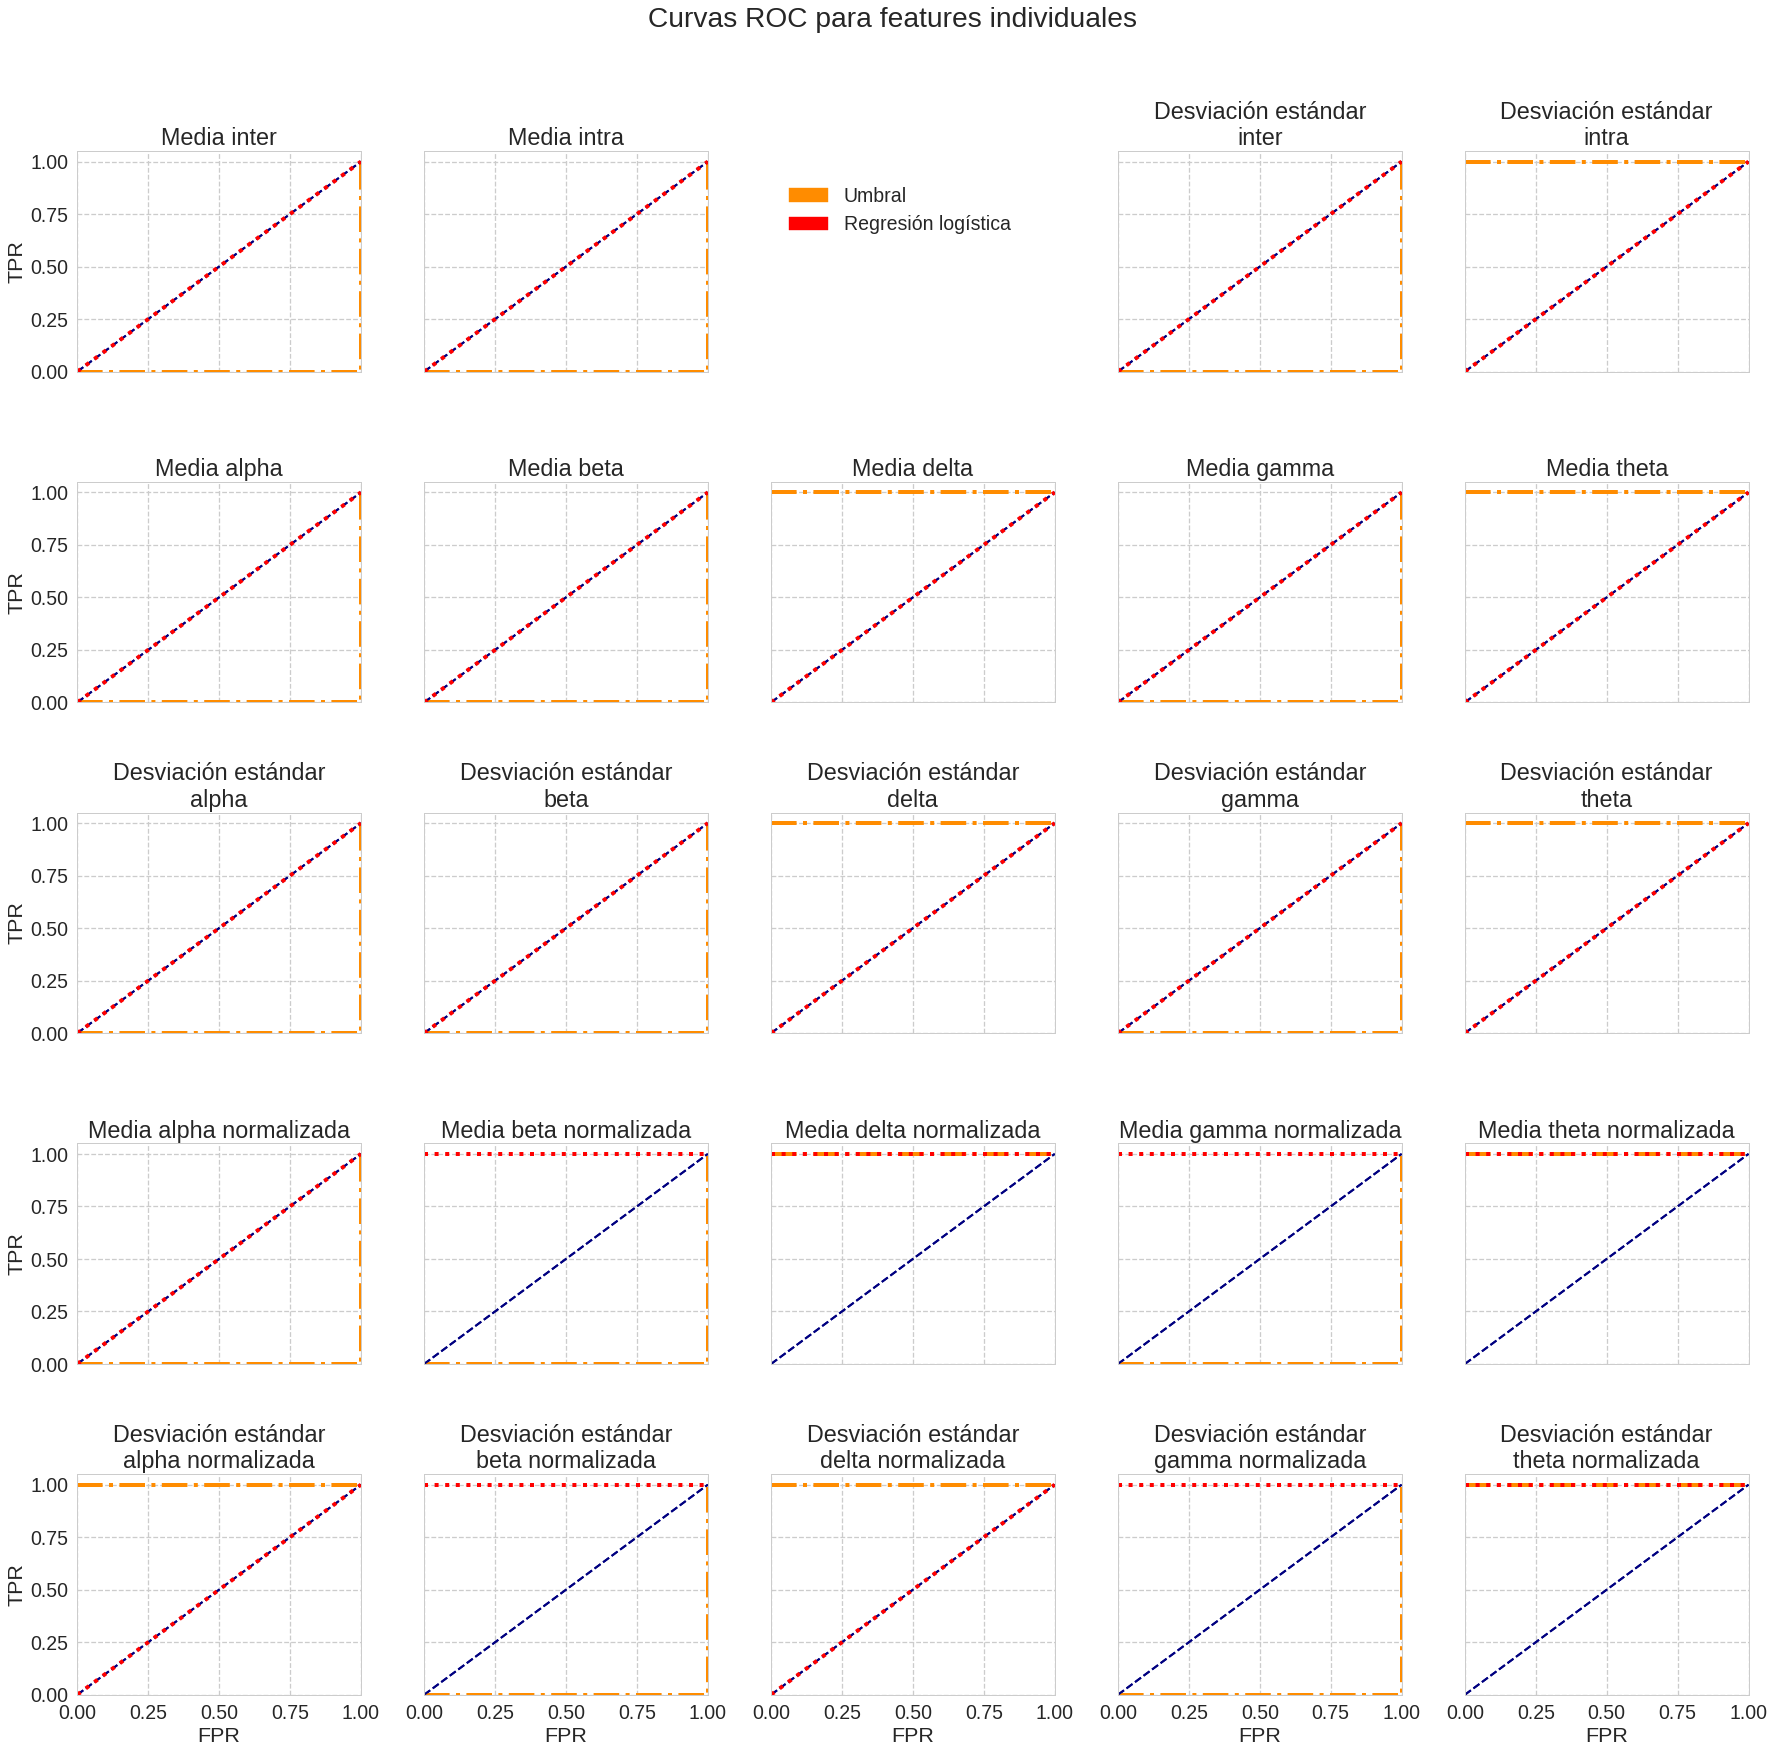

In [9]:
plt.close()

axes = dict()
fig = plt.figure(figsize=(25,25))
for son_bandas, l in [(True, c_bandas+c_bandas_norm), (False, c_entropia)]:
    for j, c in enumerate(l):
        if son_bandas:
            i = (0 if c[0] == "media" else 1) + (2 if j >=10 else 0) + 1
            j = j % 5
        else:
            i = 0
            j = j if j < 2 else (j+1)

        ax = plt.subplot2grid((5,5), (i,j))
        axes[c] = ax
        if i == 4:
            ax.set_xlabel('FPR')
        else:
            ax.xaxis.set_major_formatter(NullFormatter())

        if j == 0:
            ax.set_ylabel('TPR')
        else:
            ax.yaxis.set_major_formatter(NullFormatter())

df_metricas = pd.DataFrame(
    index=pd.MultiIndex.from_arrays(list(zip(*sorted(c_bandas + c_bandas_norm + c_entropia)))))
analisis_univariado(df_features, df_metricas, axes)
analisis_regresion_logistica(df_features, df_metricas, axes)

p_reg_log = mpatches.Patch(color='red')
p_umbral = mpatches.Patch(color='darkorange')
fig.legend(
    labels=['Umbral', 'Regresión logística'],
    handles=[p_umbral, p_reg_log],
    loc="upper center",
    bbox_to_anchor=(0.5, 0.88)
)

fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(top=0.9)
plt.suptitle("Curvas ROC para features individuales")

plt.show()

<h2>Valores de AUC</h2>
<p> Para complementar las curvas ROC, se muestra a continuación el valor de AUC para cada una de ellas.

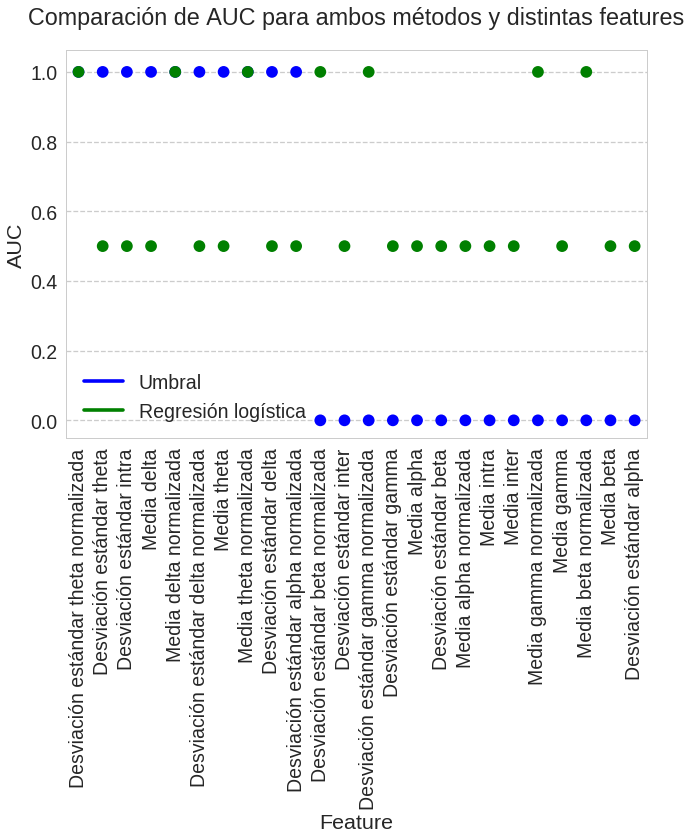

In [10]:
c_feature = "Feature"
df_auc = df_metricas.reset_index()
df_auc[c_feature] =  (df_auc["level_0"] + " " + df_auc["level_1"]).apply(nombre_bonito)

c_umbral = "Umbral"
c_reg_log = "Regresión logística"
c_feature = "Feature"
df_auc.rename(columns={"umbral_auc": c_umbral, "regLog_auc": c_reg_log}, inplace=True)
df_auc = df_auc[[c_feature, c_umbral, c_reg_log]].sort_values(c_umbral, ascending=False)

f, ax = plt.subplots(1, 1)
args = {
    "data": df_auc,
    "ax": ax,
    "x": c_feature,
    "join": False
}

plt.xticks(rotation=90)
sns.pointplot(y=c_umbral, color='blue', **args)
sns.pointplot(y=c_reg_log, color='green', **args)
ax.legend(handles=ax.lines[::len(df_auc)+1], labels=["Umbral","Regresión logística"])

plt.ylabel("AUC")
ttl = plt.title("Comparación de AUC para ambos métodos y distintas features")
ttl.set_position([.5, 1.05])

plt.show()
    

La primer observación a realizar es como el método obtiene resultados extremos: por un lado se obtienen altos valores de AUC para EJEMPLOS QUE ANDAN BIEN, mientras que con otras <i>features</i> el resultado es completamente erróneo, como en EJEMPLOS.
Sin embargo ésto no se debe a que no sean separables los valores de ambos grupos: de hecho, en los casos donde el AUC es prácticamente cero, el problema es que la predicción que se está realizando es completamente inversa a lo que debería ser.

La causa es que el método simplemente utiliza un umbral particular, clasificando luego como negativos a aquellos que estén por debajo de él y como positivos a aquellos que estén por arriba.
Si para alguna <i>feature</i> los valores difieren entre ambas clases, pero con la particularidad de que las instancias negativas tienen mayores valores, etonces el método será inútil.
Una solución sencilla sería agregar como <i>features</i> al negativo de cada una ya existente y elegir para el método umbral a aquella de las dos que sea conveniente.
Si se realizara esta modificación el método umbral no tendría casos donde el AUC sea menor a 0.5.

ALGUNA SEGUNDA OBSERVACIÓN PARA REGRESION LGÍSTICA

<h2>Validación cruzada para regresión logística</h2>
<p> Se muestra a continuación el resultado obtenido para los modelos individuales de regresión logística.


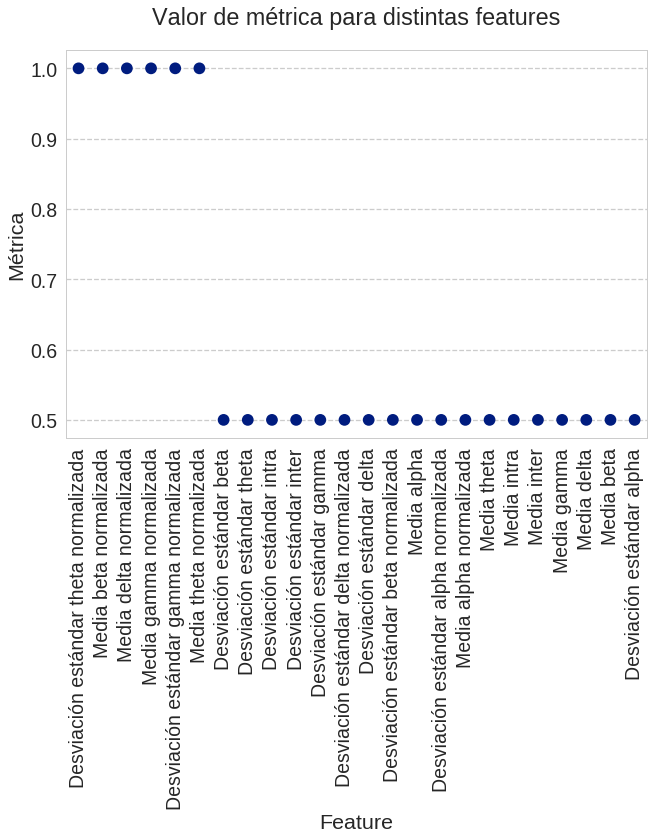

In [11]:
c_feature = "Feature"
df_reg_log = df_metricas.reset_index()
df_reg_log[c_feature] =  (df_reg_log["level_0"] + " " + df_reg_log["level_1"]).apply(nombre_bonito)
    
c_metrica = "Métrica"
df_reg_log.rename(columns={"regLog_score": c_metrica}, inplace=True)
df_reg_log = df_reg_log[[c_feature, c_metrica]].sort_values(c_metrica, ascending=False)

plt.xticks(rotation=90)
sns.pointplot(x=c_feature, y=c_metrica, data=df_reg_log, join=False)

plt.ylabel(c_metrica)
ttl = plt.title("Valor de {} para distintas features".format(c_metrica.lower()))
ttl.set_position([.5, 1.05])

plt.show()

COMENTAR ALGO DE LOS MERJORES RESULTADOS QUE SE LLEGAN A OBTENER

<h1>Análisis multivariado</h1>
<p> En esta sección se analizan los resultados obtenidos con clasificadores basados en el algoritmo de <i>Support Vector Machine</i> según dos variantes:
<ol>
    <li>Utilizar todos los <i>features</i> para entrenar el clasificador.</li>
    <li>Aplicar un <i>pipeline</i> basado en un <i>scaler</i>, <i>feature selection</i> y finalmente la clasificación utilizando SVM</li>
</ol>

In [13]:
X = df_features.drop(("valor_real", ""), axis=1)
Y = df_features["valor_real"]


In [16]:
def analisis_modelo(fitted_clf, X, Y, ax=ax, plot_ROC=True):
    classes_prob = fitted_clf.predict_proba(X)
    
    idx_class = np.where(fitted_clf.classes_ == 1)[0][0]
    predicted = classes_prob[:,idx_class]

    scores = model_selection.cross_val_score(fitted_clf, X, Y)
    final_score = sum(scores) / len(scores)

    plot_args = {
        "color": "black",
        "ls": ":"
    }

    auc = threshold_ROC(Y.values, predicted, "SVM", ax=ax, plot_ROC=plot_ROC, **plot_args)
    return auc, final_score

Para comparar los resultados de ambos clasificadores se gráfican las correspondientes curvas ROC y se calcula el score obtenido.

/home/francisco/.conda/envs/francisco/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/francisco/.conda/envs/francisco/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/francisco/.conda/envs/francisco/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/francisco/.conda/envs/francisco/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


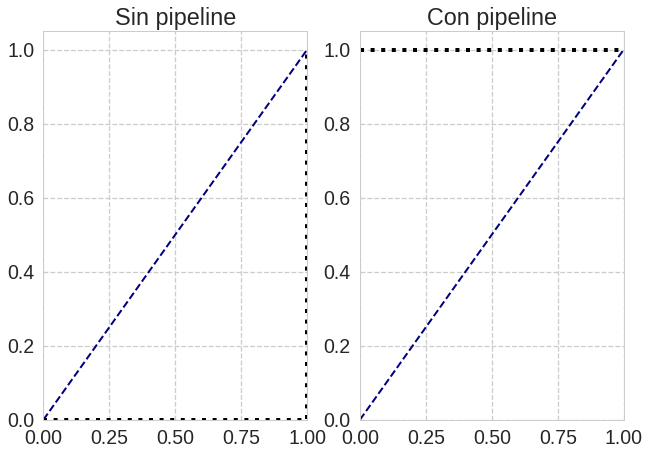

Resultados obtenidos para SVM sin pipeline
	AUC: 0.0
	Score: 1.0
Resultados obtenidos para SVM con pipeline
	AUC: 1.0
	Score: 1.0


In [18]:
f, axes = plt.subplots(1,2)

# SVM sin pipeline
clf_sin_pipeline = SVC(probability=True)
clf_sin_pipeline.fit(X,Y)

auc_sp, score_sp = analisis_modelo(clf_sin_pipeline, X, Y, ax=axes[0])

# SVM con pipeline
steps = [
    ("preprocesamiento", MinMaxScaler()),
    ("selector_features", SelectKBest(k=2)),
    ("svm", SVC(probability=True))
]

clf_con_pipeline = Pipeline(steps)
clf_con_pipeline.fit(X,Y)

auc_cp, score_cp = analisis_modelo(clf_con_pipeline, X, Y, ax=axes[1])

axes[0].set_title("Sin pipeline")
axes[1].set_title("Con pipeline")
plt.show()

for m, a, s in [("SVM sin pipeline", auc_sp, score_sp), ("SVM con pipeline", auc_cp, score_cp)]:
    print("Resultados obtenidos para", m)
    print("\tAUC:", a)
    print("\tScore:", s)


Se puede ver como al aplicar el pipeline se obtienen mejores resultados (CUALES).

El siguiente gráfico muestra cómo afecta la cantidad de features utlizadas en el score del modelo.

/home/francisco/.conda/envs/francisco/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/francisco/.conda/envs/francisco/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/francisco/.conda/envs/francisco/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/francisco/.conda/envs/francisco/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/francisco/.conda/envs/francisco/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/francisco/.conda/en

/home/francisco/.conda/envs/francisco/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/francisco/.conda/envs/francisco/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/francisco/.conda/envs/francisco/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/francisco/.conda/envs/francisco/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/francisco/.conda/envs/francisco/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/francisco/.conda/en

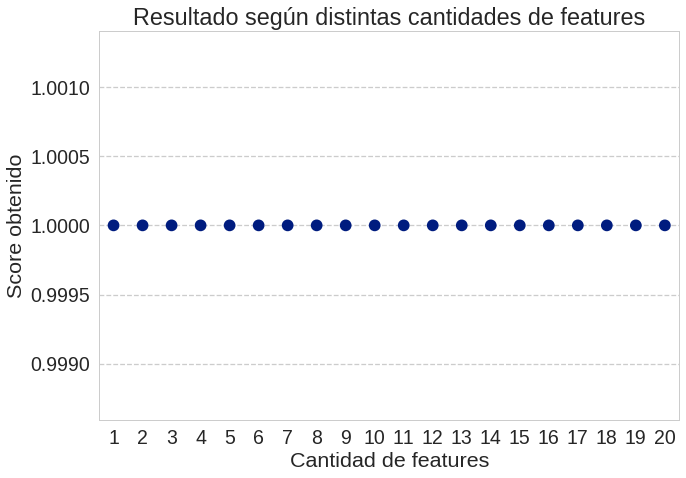

In [19]:
cantidades = list(range(1,21))
df_scores = pd.DataFrame(data={"Score":np.zeros(20)}, index=cantidades)

for mi_k in cantidades:
    # SVM con pipeline
    steps = [
        ("preprocesamiento", MinMaxScaler()),
        ("selector_features", SelectKBest(k=mi_k)),
        ("svm", SVC(probability=True))
    ]

    clf = Pipeline(steps)
    clf.fit(X,Y)

    _, score = analisis_modelo(clf, X, Y, plot_ROC=False)
    df_scores.loc[mi_k] = score
    
df_scores = df_scores.reset_index().rename(columns={"index": "Cantidad de features"}) 

sns.pointplot(data=df_scores, x="Cantidad de features", y="Score", join=False)
plt.ylabel("Score obtenido")
plt.title("Resultado según distintas cantidades de features")
plt.show()